In [3]:
%pylab inline
from io import BytesIO
import IPython.display
import hashlib
import struct

from svgpathtools import * 
import cmath

Populating the interactive namespace from numpy and matplotlib


/home/redhog/Projects/beta/InfiniteGlass/build/env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['real', 'imag']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
paths, attributes = svg2paths('base.svg')
tops = []
for i in range(1, 4):
    ipaths, iattributes = svg2paths('1t%s.svg' % i)
    tops.append(ipaths)
bottoms = []
for i in range(1, 6):
    ipaths, iattributes = svg2paths('1b%s.svg' % i)
    bottoms.append(ipaths)
    


In [5]:
def nonlinspace(l, u, n, init=b''):
    maxuint = struct.unpack(">I", b"\xff\xff\xff\xff")[0]
    m = hashlib.md5()
    m.update(init)
    res = numpy.zeros(n)
    for i in range(0, n):
        m.update(b'\0')
        res[i] = l + (u-l) * float(struct.unpack(">I", m.digest()[:4])[0]) / maxuint
    return sort(res)

In [6]:
def decorate(pth,
             bottoms,
             tops,
             padding = 5,
             nitems = 40,
             minsize=0.3,
             overlap=0.02,
             flavor = b'firepower2',
             scaling = lambda d: 1-1/(1+e**(-200*abs(d)+3)),
             include_pth=True):

    bases_bottom = [[path.scale(p, 0.5) for p in bottom] for bottom  in bottoms]
    bases_bottom = [[path.translate(p, -bbox[0]-bbox[3]*1j) for p in base]
                    for base, bbox in ((base, paths2svg.big_bounding_box(base)) for base in bases_bottom)]

    bases_top = [[path.scale(p, 0.5) for p in bottom] for bottom  in tops]
    bases_top = [[path.translate(p, -bbox[0]-bbox[2]*1j) for p in base]
                    for base, bbox in ((base, paths2svg.big_bounding_box(base)) for base in bases_top)]

    m = hashlib.md5()

    points = [(T,
               pth[s].point(t),
               cmath.phase(pth[s].unit_tangent(t)) * 360 / (2*pi),
               pth[s].normal(t),
               d
              )
              for T, (s, t), d in ((T, pth.T2t(T), pth.derivative(T, 2)) for T in nonlinspace(0, 1, nitems, flavor))]

    points = [points[i]
              for i in range(len(points))
              if i == 0 or (abs(points[i][0]-points[i-1][0]) * (360-abs(points[i][2]-points[i-1][2]))/360. > overlap)]

    opaths=[base.scaled(scaling(d)).rotated(a if T > .5 else a + 180, 0.0).translated(p).translated(padding*n)
            for idx, (T, p, a, n, d) in enumerate(points)
            for base in (bases_bottom[idx % len(bases_bottom)] if T > .5 else bases_top[idx % len(bases_top)])
            if scaling(d) > minsize]

    if include_pth:
        opaths.append(pth)

    return opaths


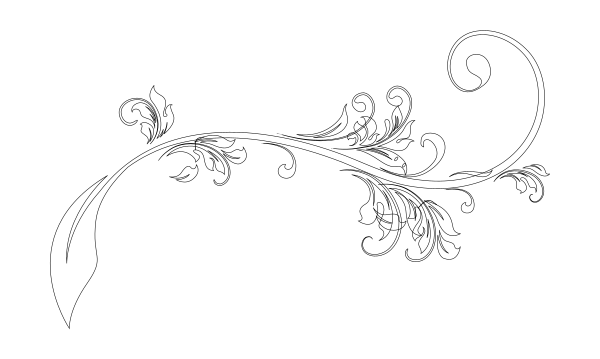

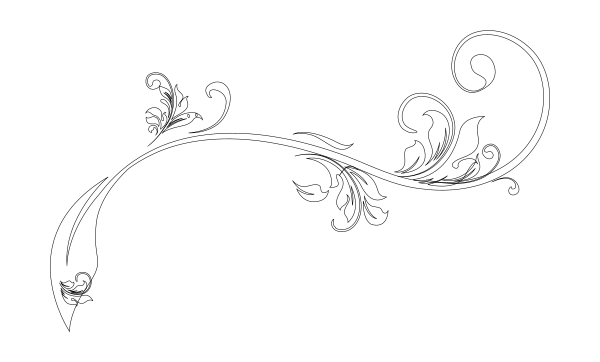

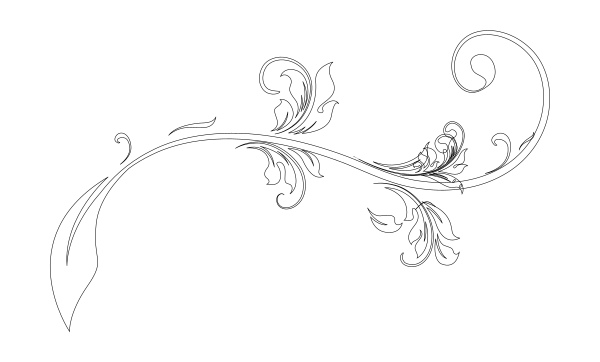

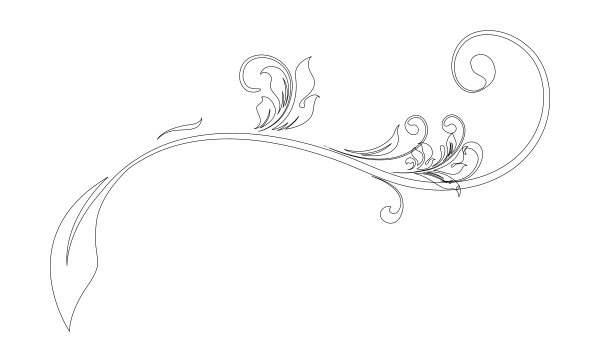

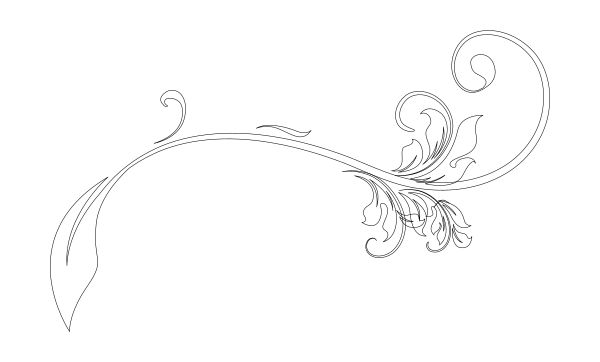

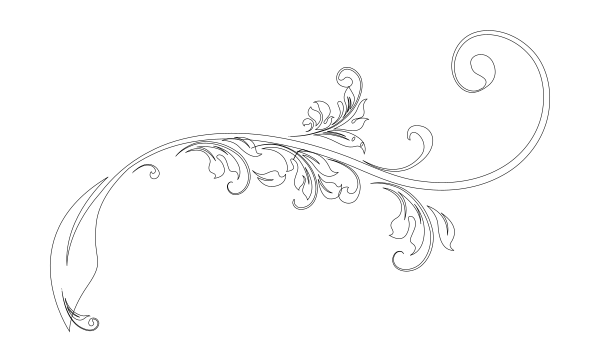

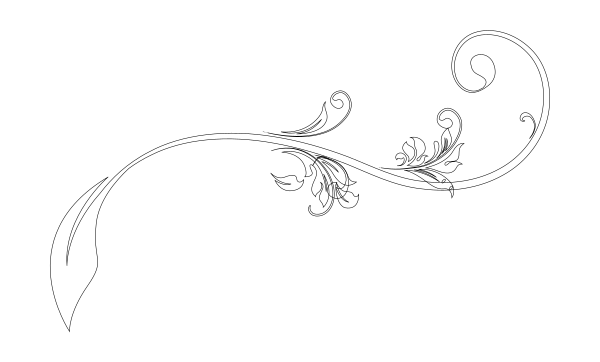

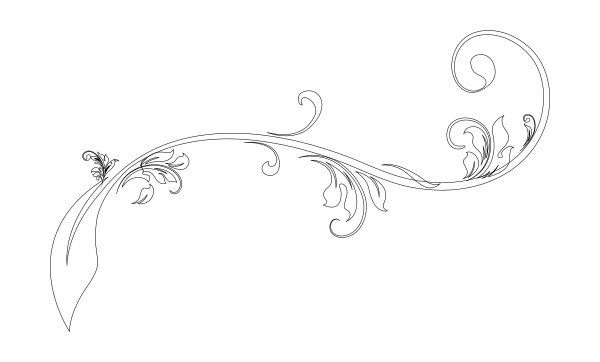

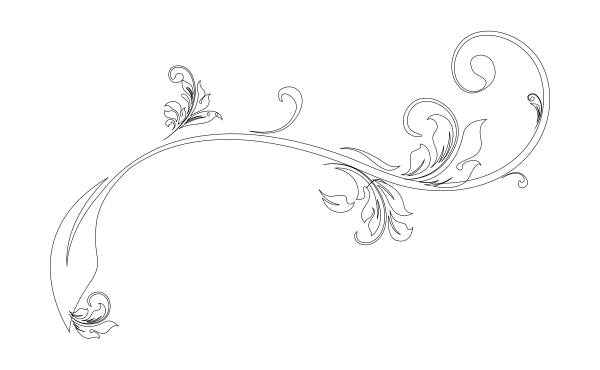

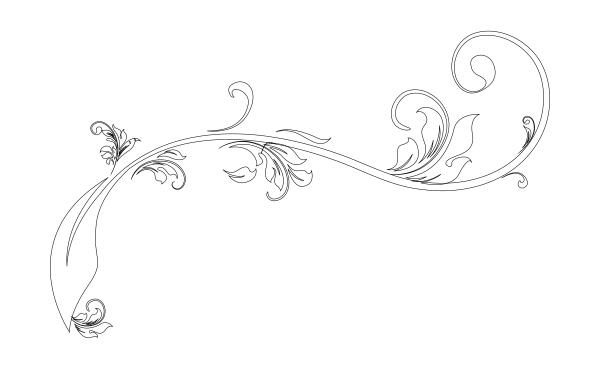

In [8]:
for flavor in range(10):
    wsvg(decorate(paths[0], bottoms, tops, flavor=str(flavor).encode("UTF-8")), filename="test.svg")
    with open("test.svg", "rb") as f:
        data = f.read()
    IPython.display.display(IPython.display.SVG(data=data))

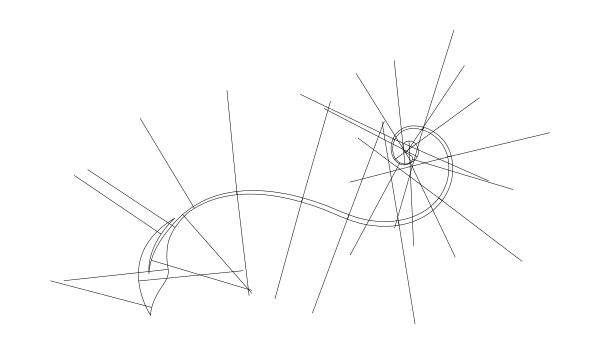

In [18]:
p = [Line(s.point(0.5), s.point(0.5)+100*s.normal(0.5)) for s in paths[0]]
p.append(paths[0])

wsvg(p, filename="test.svg")
with open("test.svg", "rb") as f:
    data = f.read()
IPython.display.display(IPython.display.SVG(data=data))

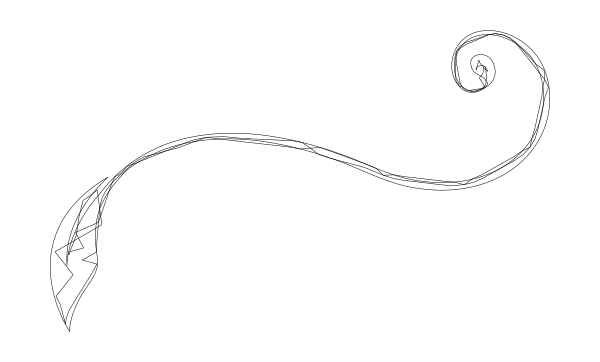

In [60]:
normals = [(s, s.point(i), paths[0].intersect(Line(s.point(0.5), s.point(0.5)+100*s.normal(0.5))))
           for s in paths[0]
           for i in linspace(0, 1, 5)]

segments = set()
def center(s1, p1, normal):
    closestdist, closestp, closests = sorted([(abs(p-p1), p, s)
                      for s, p in [(normalx[0][1], normalx[0][1].point(normalx[0][2]))
                                for normalx in normal]
                      if abs(p-p1) > 1e-10])[0]
    segments.add(id(s1))
    segments.add(id(closests))
    
    return p1 + 0.5 * (closestp -p1)

points = [center(s, p, normal) for s, p, normal in normals]

lines = [Line(points[i], points[i-1]) for i in range(1, len(points))]
out = lines + [paths[0]]

wsvg(out, filename="test.svg")
with open("test.svg", "rb") as f:
    data = f.read()
IPython.display.display(IPython.display.SVG(data=data))

In [144]:
segments = paths[0]
normals = [Line(s.point(i)+100*s.normal(i), s.point(i)-100*s.normal(i))
           for s in segments
           for i in (0.5,)]
# Normals are not defined at t = 0 and t=1!!! Hack around...
def intersectionsort(i):
    ((T1, seg1, t1), (T2, seg2, t2)) = i
    return T2
intersections = [sorted(paths[0].intersect(normal), key=intersectionsort) for normal in normals]
groupedintersectionpairs = [[(intersectionline[i*2], intersectionline[i*2+1])
                             for i in range(len(intersectionline)//2)]
                            for intersectionline in intersections]
intersectionpairs = [intersectionpair
                     for group in groupedintersectionpairs
                     for intersectionpair in group]


def distance(a, b):
    return math.sqrt((sin(a*2*pi) - sin(b*2*pi))**2 + (cos(a*2*pi) - cos(b*2*pi))**2)/2

intersectionpairswithdistance = sorted([(distance(intersectionpair[0][0][0], intersectionpair[1][0][0]), intersectionpair)
                                        for intersectionpair in intersectionpairs],
                                       key=lambda p: p[0])

T1 = (intersectionpairswithdistance[0][1][0][0][0] + intersectionpairswithdistance[0][1][1][0][0]) / 2
T2 = (intersectionpairswithdistance[1][1][0][0][0] + intersectionpairswithdistance[1][1][1][0][0]) / 2


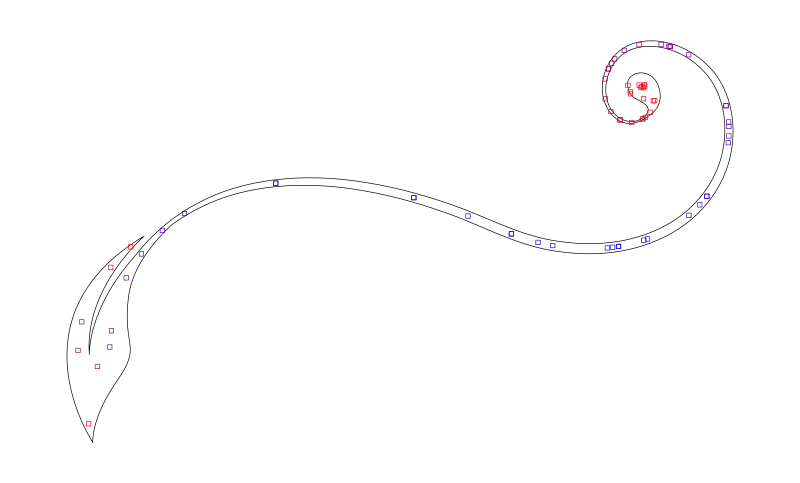

In [157]:
centerpoints = [(distance,
                 intersectionpair,
                 (paths[0].point(intersectionpair[0][0][0])
                  + paths[0].point(intersectionpair[1][0][0])) / 2)
                for distance, intersectionpair in intersectionpairswithdistance]

def marker(point, size=1):
    return path.bbox2path(point.real-size, point.real+size, point.imag-size, point.imag+size)

out = [paths[0]] + [marker(p) for d, i, p in centerpoints] #+ normals
colors = [(0,0,0)] + [(255-int(255*d),0,int(255*d)) for d, i, p in centerpoints]

#colors = [(0,0,0)] + [(255,0,0) if d > 0.2 else (0,0,255) for d, p in centerpoints] + [(0,128,0) for normal in normals]


wsvg(out, colors=colors, mindim=800, filename="test.svg")
with open("test.svg", "rb") as f:
    data = f.read()
IPython.display.display(IPython.display.SVG(data=data))

In [175]:
dmean = numpy.array([d for d, i, p in centerpoints]).mean()
dstd = numpy.array([d for d, i, p in centerpoints]).std()

orderedcenterpoints = sorted(
    [(i[0][0][0], d, i, p) for d, i, p in centerpoints]
    + [(i[1][0][0], d, i, p) for d, i, p in centerpoints],
    key = lambda a: a[0])

clusters = []
cluster = []
for T, d, i, p in orderedcenterpoints:
    if d > dmean - dstd:
        if cluster:
            clusters.append(cluster)
            cluster = []
    else:
        cluster.append((T, d, i, p))
if cluster:
    clusters.append(cluster)
    cluster = []

clusters = sorted([numpy.array([T for T, d, i, p in cluster]).mean() for cluster in clusters])
first = clusters[0]
last = clusters[1]
if last - first < .5:
    first, last = last, first


In [177]:
if first < last:
    orderedcenterpointsnocopies = [(L, d, i, p) for (L, d, i, p) in orderedcenterpoints
                                   if L >= first and L <=last]
else:
    orderedcenterpointsnocopies = ([(L, d, i, p)
                                    for (L, d, i, p) in orderedcenterpoints
                                    if L >= first] +
                                   [(L, d, i, p)
                                    for (L, d, i, p) in orderedcenterpoints
                                    if L <= first])


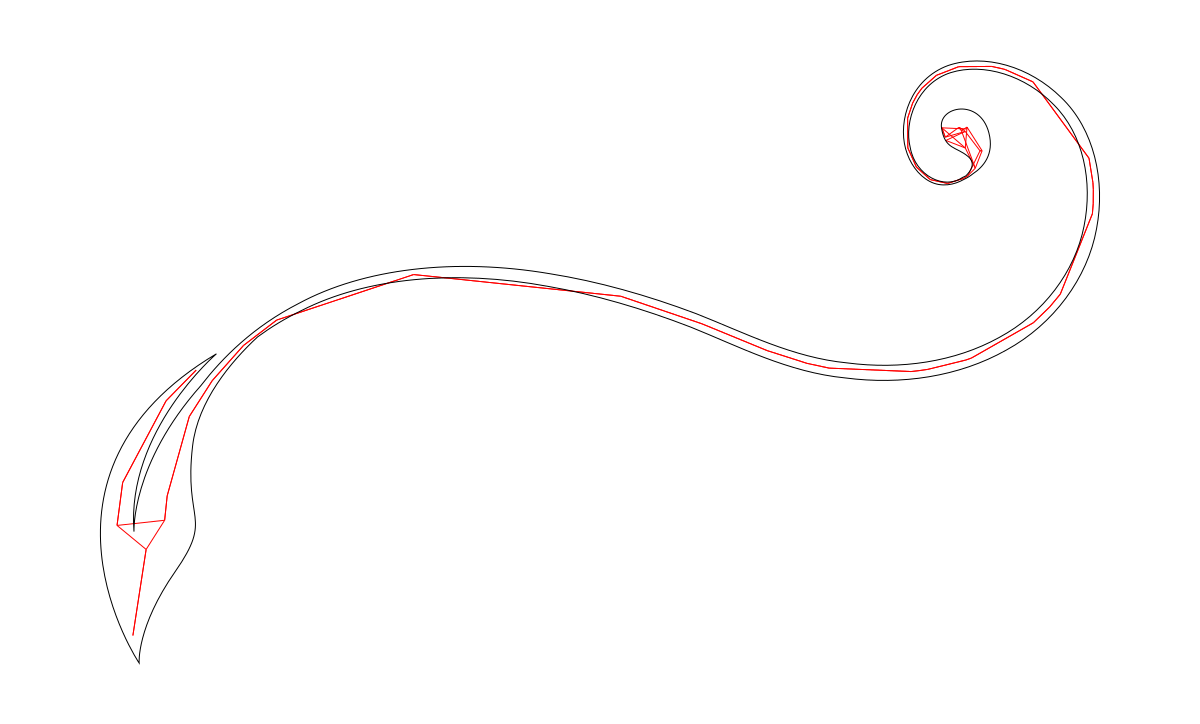

In [184]:

lines = [Line(orderedcenterpointsnocopies[i][3], orderedcenterpointsnocopies[i-1][3]) for i in range(1, len(orderedcenterpointsnocopies))]
out = lines + [paths[0]]
colors = [(255,0,0) for l in lines] + [(0,0,0)]

wsvg(out, colors=colors, mindim=1200, filename="test.svg")
with open("test.svg", "rb") as f:
    data = f.read()
IPython.display.display(IPython.display.SVG(data=data))